In [494]:
import random as rd
import time

from functools import lru_cache
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


**Reading data**

In [495]:
def read_data(path):
    global instance

    try:

        with open(path, 'r') as f:
            instance = [[int(num) for num in line.split('\t')] for line in f]
        print("\nYour matrix : \n")
        for i in instance:
            print(", ".join([str(l).rjust(4) for l in i]))
    except IOError: 
        instance="The mentioned file was not found !"
        print(instance)
        

**Dynamic programming**

In [496]:
def solve_tsp_dynamic_programming(first_city) -> Tuple[List, int]:

    '''
    Solve TSP to optimality with dynamic programming.

    Parameters
    ----------

    global instance
        Distance matrix of shape (n x n) with the (i, j) entry indicating the
        distance from node i to j.

    first_city
        Used to define the source city where the problem begins. 

    Returns
    -------

    solution
        A permutation of nodes from 1 to n that produces the least total
        distance.

    best_distance
        The total distance the optimal permutation produces.

    Notes
    -----

    Algorithm: cost of the optimal path
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    Consider a TSP instance with 3 nodes: {0, 1, 2}. Let dist(0, {1, 2}) be the
    distance from 0, visiting all nodes in {1, 2} and going back to 0. This can
    be computed recursively as:
        
        dist(ni, N) =   min   ( c_{ni, nj} + dist(nj, N - {nj}) )
                      nj in N
    and
        dist(ni, {}) = c_{ni, 0}

    With starting point as dist(0, {1, 2, ..., tsp_size}). The notation
    N - {nj} is the difference operator, meaning set N without node nj.

    Algorithm: compute the optimal path
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    The previous process returns the distance of the optimal path. To find the
    actual path, we need to store in a memory the following key/values:
        memo[(ni, N)] = nj_min

    With nj_min the node in N that provided the smallest value of dist(ni, N).
    Then, the process goes backwards starting from memo[(0, {1, 2, ..., tsp_size})].
    In the previous example, suppose memo[(0, {1, 2})] = 1.
    Then, look for memo[(1, {2})] = 2.
    Then, since the next step would be memo[2, {}], stop there. 
    The optimal path would be 0 -> 1 -> 2 -> 0.

    '''
    # Get initial set {0, 1, 2, ..., tsp_size} as a frozenset because since
    # @lru_cache requires a hashable type
    N = frozenset(range(0, len(instance)))
    N = N.difference({first_city-1})
    memo: Dict[Tuple, int] = {}

    # Step 1: get minimum distance
    @lru_cache(maxsize=len(instance)**2)
    def dist(ni, N: frozenset):
        if not N:
            return instance[ni][first_city-1]

        # Store the costs in the form (nj, dist(nj, N))    
        costs = [
            (nj, instance[ni][nj] + dist(nj, N.difference({nj})))
            for nj in N
        ]
        nmin, min_cost = min(costs, key=lambda x: x[1])
        memo[(ni, N)] = nmin
        return min_cost

    best_distance = dist(first_city-1, N)

    # Step 2: get path with the minimum distance
    ni = first_city-1
    solution = [first_city]
    while N:
        ni = memo[(ni, N)]
        solution.append(ni+1)
        N = N.difference({ni})
    solution.append(first_city)
    return solution, best_distance
    

**Real value**

In [497]:
def f(x):
    total_cost = 0
    for c in range(1,len(x)):
        total_cost += instance[x[c - 1]][x[c]]
    return total_cost
    

**Neighborhood structure**

In [498]:
def NS_swapping(x, lb, ub): #lb>0 
    bound = len(x)
    xc = None    
    if (lb < bound and ub < bound):
        xc = x.copy()
        xc[lb], xc[ub] = xc[ub], xc[lb]
    return xc

def NS_insertion_before(x, lb, ub):  #lb>0 
    bound = len(x)
    xc = None
    if (lb < bound and ub < bound):
        xc = x.copy()
        xc.insert(lb, x[ub]) 
        xc.pop(ub+1)
    return xc


def NS_two_opt(x, lb, ub):
    bound = len(x)
    x1=[]
    if lb < ub and (0 < lb < bound-1 and 0 < ub < bound-1) : 
        x1=x[:lb]
        x1.extend(reversed(x[lb:ub+1]))
        x1.extend(x[ub+1:])
    return x1
    

In [499]:
def initialization(first_city):
    bound = len(instance)
    x=[first_city]
    sol=rd.sample(range(0, bound), bound)
    for i in range(0,len(sol)-1):
        if sol[i] == first_city:
            sol.pop(i)
    x=x+sol+x
    
    return x
    

**Shaking**

In [500]:
def neighbrehood(x, k):
    bound = len(x)
    N=[]
    if(k==3):
        for i in range(1,bound-2):
            for j in range(i+1,bound-1):
                N.append(NS_swapping(x,i,j))
    elif(k==2):
        for i in range(1,bound-2):
            for j in range(i+1,bound-1):
                N.append(NS_insertion_before(x,i,j))
    elif(k==1):
        for i in range(1,bound-2):
            for j in range(i+1,bound-1):
                N.append(NS_two_opt(x,i,j))
    return N

global voisins


In [501]:
def shake(x, k):
    N=neighbrehood(x,k)
    xp=rd.choice(N)
    return xp
    

**Changing neighberhood**

In [502]:
def change_neighborhood(x, xp, k):
    if f(xp) < f(x):
        x = xp
    else:
        k += 1
    return x,k
    

**Improuve intiale solution**

In [503]:
k_max = 3
def RVNS(x, k_max, t = 5):
    start_time = time.time() 
    while time.time() - start_time < t*60:
        k=1
        while k <= k_max:
            xp = shake(x,k)  
            x, k = change_neighborhood(x, xp, k) 
    return x
    

**Local serach VND**

In [504]:
# first improvement : 
def first_improvement(x, l): 
    N=neighbrehood(x,l)
    for i in range(0,len(N)):
        if f(N[i])< f(x):
            x=N[i]
            break
    return x
    

In [505]:
l_max=2
def VND(x, l_max):
    l = 1
    while l <= l_max:
        xp = shake(x, l) 
        xp = first_improvement(x, l) 
        x,l = change_neighborhood(x, xp, l)
    return x
    

**GVNS**

In [506]:
def GVNS(x, t=5, k_max=3, l_max=2):
    start_time = time.time() 
    x=RVNS(x,k_max,0.2)
    while time.time() - start_time < t*60:
        k=1
        while k <= k_max:
            x1 = shake(x,k)  
            x2 = VND(x1, l_max)
            x, k = change_neighborhood(x, x2, k)
    return x,f(x)
    

**Get random coordinates**

In [507]:

def randomCoordsFromMatrix(matrix)->np.ndarray:
    lenght=len(matrix)
    coords=np.ndarray(shape=(lenght,2), dtype=int)
    for i in range(lenght):
        for j in range(2):
            coords[i,j]=rd.randint(10,50)
    return coords


**Target plot**

In [508]:

def targetPlot(matrix, minDistance:int, permutation: List[int]):
    lenght=len(matrix)
    coords=randomCoordsFromMatrix(matrix)
    print(f"Generated coordinates of cities : \n\n{coords} \n\n")
    cmap = plt.get_cmap('Set1')
    colors = [cmap(i) for i in np.linspace(0, 1, lenght)]

    # Figure build & display markers
    f=plt.figure(figsize=(lenght+3, lenght+3))
    ax = f.add_subplot(111)
    plt.scatter(coords[:, 0], coords[:, 1], marker='o', c=colors, s=50, edgecolor='None')
    
    # Legend build
    markers = []
    labels = [str(n+1) for n in range(lenght)]
    for i in range(lenght):
        markers.append(Line2D([0], [0], linestyle='None', marker="o", markersize=10, markeredgecolor="none", markerfacecolor=colors[i]))
    lgd = plt.legend(markers, labels, numpoints=1, bbox_to_anchor=(1.17, 0.5))

    # Plot descriptive text
    textstr = "Nombre de villes : %d\nDistance Min: %d\nVille de départ: %d" % (lenght, minDistance, permutation[0])
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.05, 0.98, textstr,transform = ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)

    # Trace the target
    start_node = permutation[0]
    
    for i in range(lenght):
        start_pos = coords[start_node-1]
        next_node = permutation[i+1] 
        end_pos = coords[next_node-1]
        ax.annotate("",
                xy=start_pos, xycoords='data',
                xytext=end_pos, textcoords='data',
                arrowprops=dict(arrowstyle="<-",
                                connectionstyle="arc3"))
        start_node = next_node
    plt.tight_layout()
    plt.axis('equal')
    plt.show()


**Main program**


Your matrix : 

   0,   12,   10,   19,    8
  12,    0,    3,    7,    2
  10,    3,    0,    6,   20
  19,    7,    6,    0,    4
   8,    2,   20,    4,    0

TSP solver

******* Menu *******
Please choose one of these methods :
(1) Solve with dynamic programming 
(2) Solve with GVNS


OPTIMAL POLICY : [3, 1, 5, 4, 2, 3]
OPTIMAL VALUE : 32



Generated coordinates of cities : 

[[32 33]
 [23 32]
 [38 21]
 [16 21]
 [10 32]] 




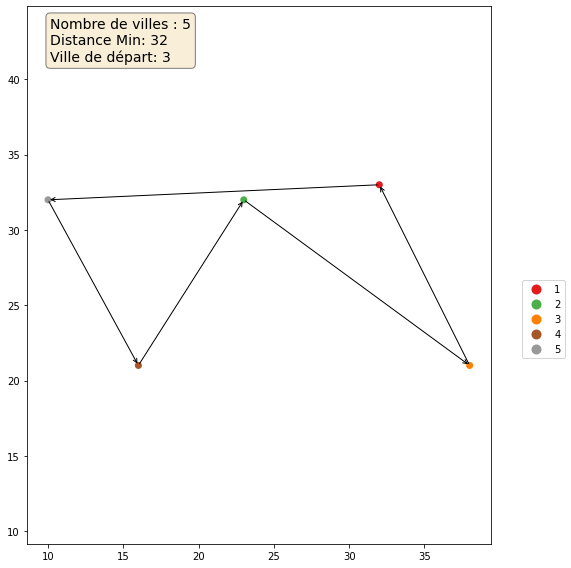

In [509]:
import os
global instance

# Matrix reading
while True:
    path=input("Put here a (.txt) instance path :\n")
    read_data(path)
    if isinstance(instance,List):
        break

# Initial program with getting user choice
print("\nTSP solver\n")
print(" Menu ".center(20, '*'))
print("Please choose one of these methods :")
print("(1) Solve with dynamic programming \n(2) Solve with GVNS")

# DP or GVNS logic according to user choice
while True:
    choice=int(input("Your choice: "))
    
    if(choice==1):
        first_city = int(input("First city : "))
        os.system("cls")
        solution, dist_min=solve_tsp_dynamic_programming(first_city)
        break
    elif(choice==2):
        first_city = int(input("First city : "))
        os.system("cls")
        x = initialization((first_city-1))
        temps = int(input("Time in minutes: ")) #minute
        solution,dist_min=GVNS(x,temps)
        for i in range(0,len(solution)) :
            solution[i]+=1
        break
    else: continue

# Outputs
print("\n\nOPTIMAL POLICY : {}".format(solution))
print("OPTIMAL VALUE : {}".format(dist_min))
print("\n\n")
targetPlot(instance,dist_min,solution)
